# **CDS Project: Part 3**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  

## Learning objectives
---

- Choose an ML model architecture for vulnerability prediction
- Preprocess the dataset you created in project part 2 to fit the model you selected
- Split the dataset for cross validation
- Create the model training pipeline, train the model using the train set and optimize the model using the test set
- Create loss graphs of the learning behaviour
- Generate predictions for the validation set
- Evaluate the results using appropriate metrics (add questions: reduce overfitting? optional 5-fold cross validation)


## Materials
---

- Lecture Slides 2, 3, 5 and 6, 9.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
- 


## Project Description

In this project, you will create, train and evaluate your own machine learning model to predict vulnerabilities in source code. In addition, you will preprocess the data to prepare it to be used in the learning pipeline.
You will be using the dataset created in part 2 in this part. 

## **Task 1**

- There are several ML model architectures that you can use for vulnerabilitiy prediction such as RNN, CNN, Multilabel Perceptron (MLP), Gated Recurrent Units (GRU) and so on. Choose a suitable ML model architecture for your project based on the strenghts and weaknesses of these algorithms.

- For the model architecture, you can choose from 2 paths:
  1. Preprocess the functions into vectors and continue the learning process similar to project 1.
  For instance, the code in the dataset needs to be converted into some type of vector representation that can be processed by a machine. After selecting a suitable model, preprocess the content in your dataset accordingly. Several models are available to preprocess code data such as:
    - Code2Vec: https://code2vec.org/
    - CodeBERT: https://github.com/microsoft/CodeBERT/tree/master/UniXcoder
    - CodeT5: https://github.com/salesforce/CodeT5

  2. Choose a model architecture that is capable of handeling raw text inputs (LSTM, GRU, etc.) as an input layer. Further information on text processing using pytorch:
    - https://pytorch.org/text/stable/index.html
    - https://pytorch.org/tutorials/


## Task 2

- Split your dataset appropriately into train, test, and validation set and justify your split.  

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv("label_dataset_final.csv")  
print(f"Dataset shape: {data.shape}")
print("\nClass distribution:")
print(data['label'].value_counts(normalize=True))

# Stratified split to maintain vulnerability ratio
X = data['source code']  
y = data['label']        

# First split: 80% train, 20% temp (test+val)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,  # For reproducibility
    stratify=y        # Maintain class balance
)

# Second split: 10% test, 10% val (from temp)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.5,    # Split temp 50/50
    random_state=42,
    stratify=y_temp   # Maintain balance in test/val
)

print("\nSplit sizes:")
print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")
print(f"Validation: {len(X_val)} samples")

# Verify distributions
print("\nClass distribution verification:")
print("Train:", y_train.value_counts(normalize=True))
print("Test:", y_test.value_counts(normalize=True))
print("Validation:", y_val.value_counts(normalize=True))



Dataset shape: (2129, 2)

Class distribution:
label
non-vulnerable    0.574448
vulnerable        0.425552
Name: proportion, dtype: float64

Split sizes:
Train: 1703 samples
Test: 213 samples
Validation: 213 samples

Class distribution verification:
Train: label
non-vulnerable    0.574281
vulnerable        0.425719
Name: proportion, dtype: float64
Test: label
non-vulnerable    0.57277
vulnerable        0.42723
Name: proportion, dtype: float64
Validation: label
non-vulnerable    0.577465
vulnerable        0.422535
Name: proportion, dtype: float64


## Task 3
- Create a preprocessing and training/test pipeline. This can also be done in separate steps.
- Train the model on a small dataset (e.g.: 1000 samples depending on the computational capacity) and make sure everything is working properly
- Show a graph showing the changes in loss function druring the training epochs 
- Select proper metrics to evaluate the performance of the model
- If everything works well, then change the model parameters (e.g: number of neurons, layer depth) and regenerate the results. Comapare these results with your previous results and elaborate your findings.

In [ ]:
# TODO: Implement your ML pipeline and perform evaluation

In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


class Config:
    SEED = 42
    SAMPLE_SIZE = 1000  # Reduced dataset size
    BATCH_SIZE = 8
    EMBEDDING_MODEL = "microsoft/codebert-base"
    MAX_LENGTH = 512
    EARLY_STOP_PATIENCE = 5
    NUM_EPOCHS = 20

torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

#Data Preparation
print("Loading and preparing data...")
data = pd.read_csv("label_dataset_final.csv").sample(n=Config.SAMPLE_SIZE, random_state=Config.SEED)
X = data['source code']

label_map = {'vulnerable': 1, 'non-vulnerable': 0}
y = data['label'].map(label_map)



# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=Config.SEED)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=Config.SEED)

Loading and preparing data...


In [11]:
#Embedding Generation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(Config.EMBEDDING_MODEL)
embedding_model = AutoModel.from_pretrained(Config.EMBEDDING_MODEL).to(device)

def generate_embeddings(text_series):
    embeddings = []
    for i in tqdm(range(0, len(text_series), Config.BATCH_SIZE), desc="Generating embeddings"):
        batch = text_series.iloc[i:i+Config.BATCH_SIZE].tolist()
        inputs = tokenizer(
            batch, return_tensors="pt",
            truncation=True, max_length=Config.MAX_LENGTH,
            padding="max_length"
        ).to(device)
        with torch.no_grad():
            outputs = embedding_model(**inputs)
        embeddings.extend(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return np.array(embeddings)

X_train_emb = generate_embeddings(X_train)
X_test_emb = generate_embeddings(X_test)
X_val_emb = generate_embeddings(X_val)


Generating embeddings: 100%|████████████████████| 13/13 [00:18<00:00,  1.41s/it]


In [12]:
# Model-Base 
class BaseVulnClassifier(nn.Module):
    def __init__(self, input_size=768):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

In [13]:
#Training 
def train_model(model, train_loader, val_loader, model_name="Base Model"):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    
    train_losses = []
    val_losses = []
    val_f1s = []
    best_f1 = 0
    patience_counter = 0
    
    for epoch in range(Config.NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
       
        model.eval()
        val_preds = []
        val_true = []
        val_loss = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend((outputs > 0.5).float().cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_f1 = f1_score(val_true, val_preds)
        val_f1s.append(val_f1)
        
        print(f"\n{model_name} - Epoch {epoch+1}:")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f}")
        
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model_name.lower().replace(' ', '_')}.pth")
        else:
            patience_counter += 1
            if patience_counter >= Config.EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Val F1')
    plt.title(f"{model_name} Validation F1")
    plt.legend()
    plt.show()
    
    return train_losses, val_losses, val_f1s


In [9]:
# Evaluation 
def evaluate_model(model, dataset, y_true, name="Set"):
    model.eval()
    loader = DataLoader(dataset, batch_size=Config.BATCH_SIZE)
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().squeeze()
            all_probs.extend(outputs.numpy())
            all_preds.extend((outputs > 0.5).float().numpy())
    
    print(f"\n{name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, all_preds):.4f}")
    print(f"Precision: {precision_score(y_true, all_preds, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, all_preds):.4f}")
    print(f"F1 Score: {f1_score(y_true, all_preds):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, all_probs):.4f}")

In [14]:
# DataLoaders
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train_emb, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    ), 
    batch_size=Config.BATCH_SIZE, shuffle=True
)

val_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_val_emb, dtype=torch.float32),
        torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
    ),
    batch_size=Config.BATCH_SIZE
)

test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test_emb, dtype=torch.float32),
        torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    ),
    batch_size=Config.BATCH_SIZE
)


Training Base Model...


Epoch 1: 100%|███████████████████████████████| 100/100 [00:00<00:00, 780.64it/s]



Base Model - Epoch 1:
Train Loss: 0.6913 | Val Loss: 0.6843 | Val F1: 0.0000


Epoch 2: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1308.78it/s]



Base Model - Epoch 2:
Train Loss: 0.6861 | Val Loss: 0.6814 | Val F1: 0.0000


Epoch 3: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1332.27it/s]



Base Model - Epoch 3:
Train Loss: 0.6857 | Val Loss: 0.6796 | Val F1: 0.0000


Epoch 4: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1313.65it/s]



Base Model - Epoch 4:
Train Loss: 0.6782 | Val Loss: 0.6766 | Val F1: 0.2000


Epoch 5: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1342.37it/s]



Base Model - Epoch 5:
Train Loss: 0.6758 | Val Loss: 0.6772 | Val F1: 0.2000


Epoch 6: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1264.09it/s]



Base Model - Epoch 6:
Train Loss: 0.6707 | Val Loss: 0.6771 | Val F1: 0.2456


Epoch 7: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1294.57it/s]



Base Model - Epoch 7:
Train Loss: 0.6723 | Val Loss: 0.6828 | Val F1: 0.0851


Epoch 8: 100%|██████████████████████████████| 100/100 [00:00<00:00, 1290.87it/s]



Base Model - Epoch 8:
Train Loss: 0.6700 | Val Loss: 0.6901 | Val F1: 0.0000


Epoch 9: 100%|███████████████████████████████| 100/100 [00:00<00:00, 934.19it/s]



Base Model - Epoch 9:
Train Loss: 0.6701 | Val Loss: 0.6716 | Val F1: 0.2000


Epoch 10: 100%|█████████████████████████████| 100/100 [00:00<00:00, 1264.33it/s]



Base Model - Epoch 10:
Train Loss: 0.6614 | Val Loss: 0.6790 | Val F1: 0.1250


Epoch 11: 100%|█████████████████████████████| 100/100 [00:00<00:00, 1322.24it/s]



Base Model - Epoch 11:
Train Loss: 0.6609 | Val Loss: 0.6754 | Val F1: 0.2000
Early stopping at epoch 11


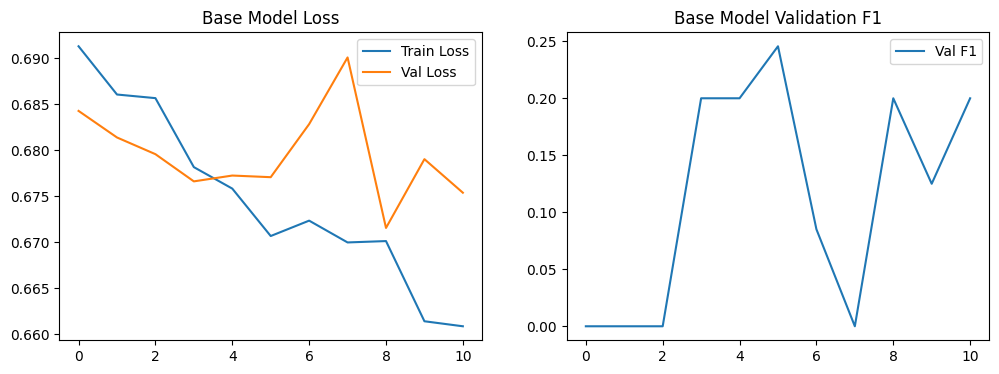


Base Model - Train Evaluation:
Accuracy: 0.5925
Precision: 0.5843
Recall: 0.2740
F1 Score: 0.3731
ROC AUC: 0.6210

Base Model - Val Evaluation:
Accuracy: 0.5700
Precision: 0.5385
Recall: 0.1591
F1 Score: 0.2456
ROC AUC: 0.5735

Base Model - Test Evaluation:
Accuracy: 0.6300
Precision: 0.6522
Recall: 0.3409
F1 Score: 0.4478
ROC AUC: 0.6494


In [73]:
#Train and Evaluate Base Model
print("\nTraining Base Model...")
base_model = BaseVulnClassifier()
base_train_loss, base_val_loss, base_val_f1 = train_model(base_model, train_loader, val_loader)

# Load  base model
base_model.load_state_dict(torch.load("best_base_model.pth"))
evaluate_model(base_model, train_loader.dataset, y_train, "Base Model - Train")
evaluate_model(base_model, val_loader.dataset, y_val, "Base Model - Val")
evaluate_model(base_model, test_loader.dataset, y_test, "Base Model - Test")


Training Enhanced Model...


Epoch 1: 100%|███████████████████████████████| 100/100 [00:00<00:00, 330.53it/s]



Enhanced Model - Epoch 1:
Train Loss: 0.6943 | Val Loss: 0.6899 | Val F1: 0.5474


Epoch 2: 100%|███████████████████████████████| 100/100 [00:00<00:00, 404.19it/s]



Enhanced Model - Epoch 2:
Train Loss: 0.6751 | Val Loss: 0.6908 | Val F1: 0.2941


Epoch 3: 100%|███████████████████████████████| 100/100 [00:00<00:00, 402.96it/s]



Enhanced Model - Epoch 3:
Train Loss: 0.6741 | Val Loss: 0.7082 | Val F1: 0.3659


Epoch 4: 100%|███████████████████████████████| 100/100 [00:00<00:00, 403.90it/s]



Enhanced Model - Epoch 4:
Train Loss: 0.6764 | Val Loss: 0.6864 | Val F1: 0.3824


Epoch 5: 100%|███████████████████████████████| 100/100 [00:00<00:00, 395.17it/s]



Enhanced Model - Epoch 5:
Train Loss: 0.6769 | Val Loss: 0.6902 | Val F1: 0.4000


Epoch 6: 100%|███████████████████████████████| 100/100 [00:00<00:00, 342.74it/s]



Enhanced Model - Epoch 6:
Train Loss: 0.6540 | Val Loss: 0.6903 | Val F1: 0.2769
Early stopping at epoch 6


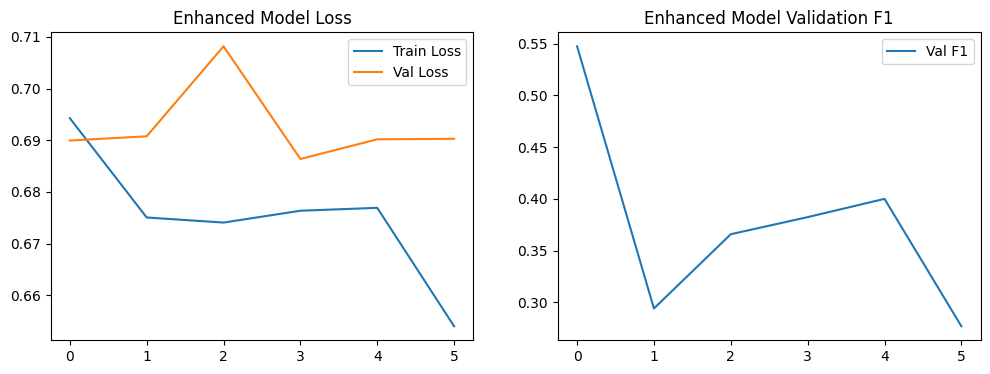


Enhanced Model - Train Evaluation:
Accuracy: 0.5938
Precision: 0.5413
Recall: 0.5367
F1 Score: 0.5390
ROC AUC: 0.6175

Enhanced Model - Val Evaluation:
Accuracy: 0.5700
Precision: 0.5098
Recall: 0.5909
F1 Score: 0.5474
ROC AUC: 0.5495

Enhanced Model - Test Evaluation:
Accuracy: 0.5600
Precision: 0.5000
Recall: 0.6364
F1 Score: 0.5600
ROC AUC: 0.5775


In [15]:
#Enhanced Model with More Capacity
class EnhancedVulnClassifier(nn.Module):
    def __init__(self, input_size=768):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Train and Evaluate Enhanced Model
print("\nTraining Enhanced Model...")
enhanced_model = EnhancedVulnClassifier()
enhanced_train_loss, enhanced_val_loss, enhanced_val_f1 = train_model(
    enhanced_model, train_loader, val_loader, "Enhanced Model"
)

# Loadenhanced model
enhanced_model.load_state_dict(torch.load("best_enhanced_model.pth"))
evaluate_model(enhanced_model, train_loader.dataset, y_train, "Enhanced Model - Train")
evaluate_model(enhanced_model, val_loader.dataset, y_val, "Enhanced Model - Val")
evaluate_model(enhanced_model, test_loader.dataset, y_test, "Enhanced Model - Test")


<Figure size 1500x500 with 0 Axes>

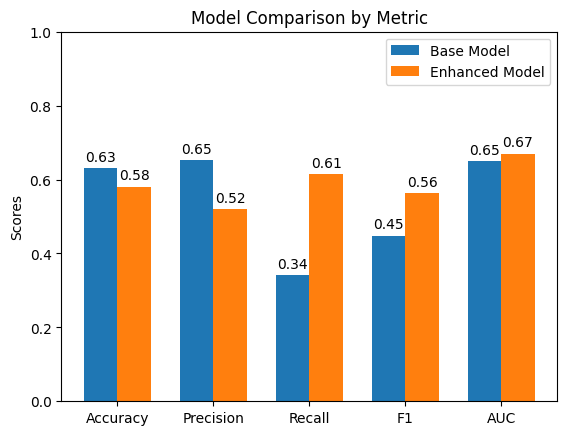

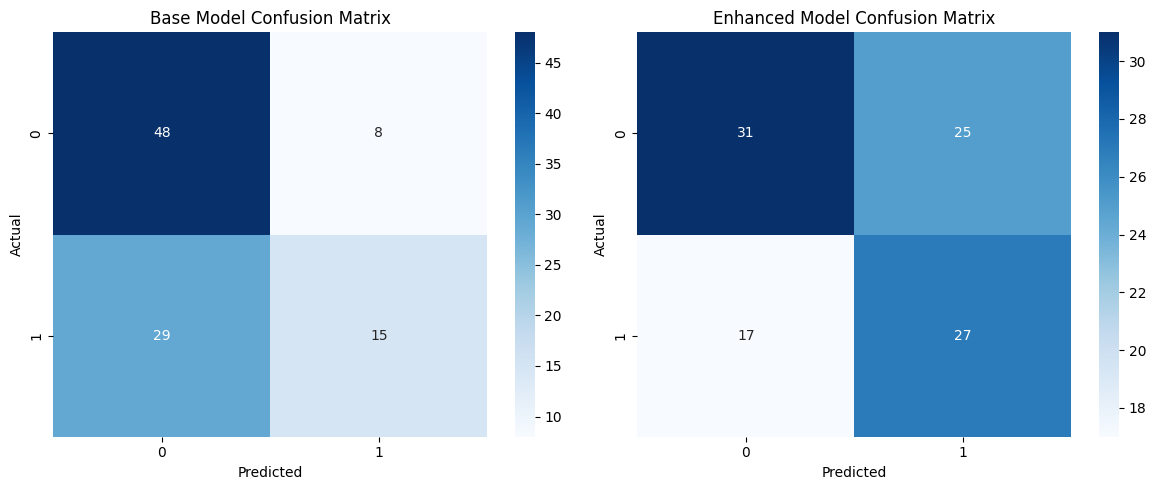

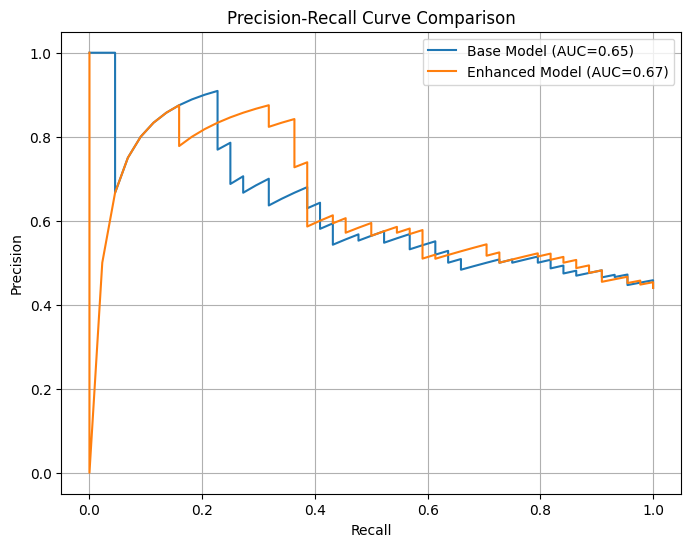


Detailed Metric Comparison:
               Accuracy Precision    Recall        F1       AUC  \
Base Model         0.63  0.652174  0.340909  0.447761  0.649351   
Enhanced Model     0.58  0.519231  0.613636    0.5625  0.670049   

                                  CM  
Base Model       [[48, 8], [29, 15]]  
Enhanced Model  [[31, 25], [17, 27]]  

Recommended Optimal Thresholds:
Base Model: 0.301
Enhanced Model: 0.219


In [78]:



def compare_models(y_true, base_probs, enhanced_probs, base_thresh=0.5, enhanced_thresh=0.5):
    # Calculate metrics for both models
    base_preds = (base_probs > base_thresh).astype(int)
    enhanced_preds = (enhanced_probs > enhanced_thresh).astype(int)
    
    # Get metrics
    metrics = {
        'Base Model': {
            'Accuracy': accuracy_score(y_true, base_preds),
            'Precision': precision_score(y_true, base_preds),
            'Recall': recall_score(y_true, base_preds),
            'F1': f1_score(y_true, base_preds),
            'AUC': roc_auc_score(y_true, base_probs),
            'CM': confusion_matrix(y_true, base_preds)
        },
        'Enhanced Model': {
            'Accuracy': accuracy_score(y_true, enhanced_preds),
            'Precision': precision_score(y_true, enhanced_preds),
            'Recall': recall_score(y_true, enhanced_preds),
            'F1': f1_score(y_true, enhanced_preds),
            'AUC': roc_auc_score(y_true, enhanced_probs),
            'CM': confusion_matrix(y_true, enhanced_preds)
        }
    }
    
    #Metric comparison visualization
    plt.figure(figsize=(15, 5))
    
    # Bar chart comparison
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    x = np.arange(len(metrics_to_plot))
    width = 0.35
    
    fig, ax = plt.subplots()
    base_values = [metrics['Base Model'][m] for m in metrics_to_plot]
    enhanced_values = [metrics['Enhanced Model'][m] for m in metrics_to_plot]
    
    rects1 = ax.bar(x - width/2, base_values, width, label='Base Model')
    rects2 = ax.bar(x + width/2, enhanced_values, width, label='Enhanced Model')
    
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison by Metric')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot)
    ax.legend()
    ax.set_ylim(0, 1)
    
    #  value labels
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.show()
    
    #Confusion matrix visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Base model CM
    cm_base = metrics['Base Model']['CM']
    sns.heatmap(cm_base, annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_title('Base Model Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # Enhanced model CM
    cm_enhanced = metrics['Enhanced Model']['CM']
    sns.heatmap(cm_enhanced, annot=True, fmt='d', ax=ax2, cmap='Blues')
    ax2.set_title('Enhanced Model Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    #Precision-Recall curves
    plt.figure(figsize=(8, 6))
    
    # Base model curve
    precision, recall, _ = precision_recall_curve(y_true, base_probs)
    plt.plot(recall, precision, label=f'Base Model (AUC={metrics["Base Model"]["AUC"]:.2f})')
    
    # Enhanced model curve
    precision, recall, _ = precision_recall_curve(y_true, enhanced_probs)
    plt.plot(recall, precision, label=f'Enhanced Model (AUC={metrics["Enhanced Model"]["AUC"]:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend()
    plt.grid()
    plt.show()
    
    return metrics

# Generate predictions 
base_probs = base_model(torch.tensor(X_test_emb, dtype=torch.float32)).detach().numpy()
enhanced_probs = enhanced_model(torch.tensor(X_test_emb, dtype=torch.float32)).detach().numpy()

# Run comparison
comparison_results = compare_models(y_test, base_probs.squeeze(), enhanced_probs.squeeze())

# Print metric tables
print("\nDetailed Metric Comparison:")
print(pd.DataFrame(comparison_results).transpose().round(4))

#Threshold analysis
print("\nRecommended Optimal Thresholds:")
base_prec, base_rec, base_thresh = precision_recall_curve(y_test, base_probs)
enh_prec, enh_rec, enh_thresh = precision_recall_curve(y_test, enhanced_probs)

# Find thresholds where recall >= 0.6
base_optimal_idx = np.where(base_rec >= 0.6)[0][0]
enh_optimal_idx = np.where(enh_rec >= 0.6)[0][0]

print(f"Base Model: {base_thresh[base_optimal_idx]:.3f}")
print(f"Enhanced Model: {enh_thresh[enh_optimal_idx]:.3f}")